<a href="https://colab.research.google.com/github/dragoa/MachineLearning/blob/main/DL/L4_Images_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GANs

In this lab we will practice the use of Generative Adversarial Networks (GANs) on images. The choice of such data is guided by the fact the generated samples can be easily visually inspected to appreciate the quality.


In [1]:
# we start importing some libraries
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
from keras.datasets import fashion_mnist
from keras.optimizers.legacy import Adam, RMSprop, SGD
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal

from matplotlib import pyplot as plt
import numpy as np
from math import sqrt

In [2]:
# we load the data, the fashion_mnist dataset, and we visualize some examples
(X_train, _), (_, _) = fashion_mnist.load_data()

print('X_train:', X_train.shape)

4422102/4422102 [==============================] - 0s 0us/step
X_train: (60000, 28, 28)


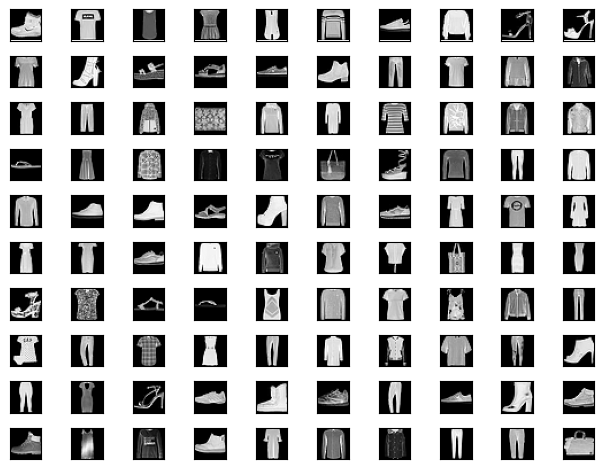

In [3]:
# we visualize some data

for i in range(0, 100):
    plt.subplot(10, 10, 1 + i, xticks=[], yticks=[])
    plt.imshow(np.squeeze(X_train[i]),cmap='gray')

plt.tight_layout()

In [4]:
# the generator is using tanh activation in the last layer, for which we need to preprocess
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

In [5]:
# A function to generate random inputs
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [6]:
# A function to sample a training point
def sample_real_data(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples)
    X = X_train[ix]
    y = ones((n_samples, 1))
    return X, y

In [7]:
# A function to generate a fake input from a random point
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)
    y = zeros((n_samples, 1))
    return images, y

In [8]:
# To print a summary of the training
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        plt.subplot(10, 10, 1 + i)
        plt.axis('off')
        plt.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))

In [9]:
def save_plot(examples, n_examples):
    for i in range(n_examples):
        plt.subplot(int(sqrt(n_examples)), int(sqrt(n_examples)), 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

In [10]:
# define the structure of the discriminator (binary classifier real-fake)

def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [11]:
# build the discriminator

discriminator = define_discriminator()
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 1024)              803840    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0     

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
# define the generator

def define_generator(latent_dim):
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,))
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model

In [13]:
# build the generator
latent_dim = 5
generator = define_generator(latent_dim)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_4 (Dense)             (None, 256)               1536      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1024)              0   

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


                                                                 
 dense_7 (Dense)             (None, 784)               803600    
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 1462032 (5.58 MB)
Trainable params: 1462032 (5.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# define the GANs architecture

def define_gan(g_model, d_model):
    d_model.trainable = False
    #g_model.trainable = True
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [15]:
gan_model = define_gan(generator, discriminator)
gan_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_4 (Dense)             (None, 256)               1536      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1024)              0   

In [16]:
def plot_loss(d_loss,g_loss, dim):
    plt.close()
    plt.figure(figsize=dim)
    plt.plot(d_loss)
    plt.plot(g_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Iteration')
    plt.legend(['Discriminator', 'Generator'], loc='upper right')
    plt.show()

def plot_acc(d_acc,g_acc, dim):
    plt.close()
    plt.figure(figsize=dim)
    plt.plot(d_acc)
    plt.plot(g_acc)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Iteration')
    plt.legend(['Discriminator', 'Generator'], loc='upper right')
    plt.show()

In [17]:
# Training function

def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs=100, n_batch=64):

    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs

    d_loss_vec = []
    g_loss_vec = []

    d_acc_vec = [];
    g_acc_vec = [];

    for i in range(n_steps):

        d_loss_b = []
        g_loss_b = []

        d_acc_b = [];
        g_acc_b = [];

        X_real, y_real = sample_real_data(X_train, n_batch)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)

        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)

        d_loss_b.append((d_loss_r + d_loss_f)/2)
        d_acc_b.append((d_acc_r + d_acc_f)/2)


        z_input = generate_latent_points(latent_dim, n_batch)
        y_gan = ones((n_batch, 1))
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)

        g_loss_b.append(g_loss)
        g_acc_b.append(g_acc)

        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
        if (i+1) % (bat_per_epo * 1) == 0:

            summarize_performance(i, g_model, latent_dim)

            d_loss_vec.append(np.mean(d_loss_b))
            g_loss_vec.append(np.mean(g_loss_b))
            d_acc_vec.append(np.mean(d_acc_b))
            g_acc_vec.append(np.mean(g_acc_b))

            d_loss_b = []
            g_loss_b = []

            d_acc_b = [];
            g_acc_b = [];

            plot_loss(d_loss_vec,g_loss_vec, (6,4))
            plot_acc(d_acc_vec,g_acc_vec, (6,4))


2/2 [==============================] - 0s 6ms/step
>1, dr[0.589,0.656], df[0.698,0.000], g[0.690,1.000]
2/2 [==============================] - 0s 5ms/step
>2, dr[0.087,0.984], df[0.699,0.000], g[0.689,1.000]
2/2 [==============================] - 0s 4ms/step
>3, dr[0.019,1.000], df[0.700,0.000], g[0.688,0.984]
2/2 [==============================] - 0s 4ms/step
>4, dr[0.009,1.000], df[0.703,0.000], g[0.688,0.938]
2/2 [==============================] - 0s 4ms/step
>5, dr[0.010,1.000], df[0.706,0.000], g[0.685,0.984]
2/2 [==============================] - 0s 4ms/step
>6, dr[0.006,1.000], df[0.715,0.000], g[0.680,0.984]
2/2 [==============================] - 0s 4ms/step
>7, dr[0.005,1.000], df[0.723,0.000], g[0.673,1.000]
2/2 [==============================] - 0s 4ms/step
>8, dr[0.009,1.000], df[0.736,0.000], g[0.657,1.000]
2/2 [==============================] - 0s 4ms/step
>9, dr[0.004,1.000], df[0.759,0.000], g[0.650,1.000]
2/2 [==============================] - 0s 5ms/step
>10, dr[0.008

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved: model_0937.h5


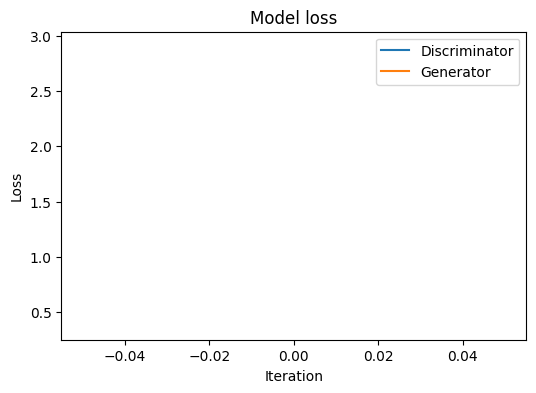

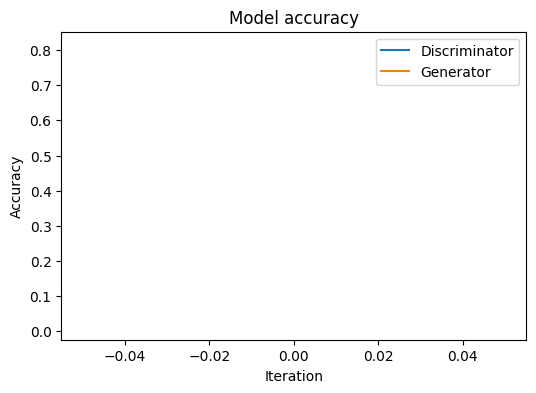

2/2 [==============================] - 0s 5ms/step
>938, dr[0.418,0.797], df[0.405,0.891], g[2.818,0.000]
2/2 [==============================] - 0s 5ms/step
>939, dr[0.300,0.828], df[0.275,0.922], g[2.964,0.016]
2/2 [==============================] - 0s 10ms/step
>940, dr[0.310,0.844], df[0.294,0.922], g[2.925,0.000]
2/2 [==============================] - 0s 10ms/step
>941, dr[0.351,0.812], df[0.325,0.891], g[2.862,0.047]
2/2 [==============================] - 0s 10ms/step
>942, dr[0.390,0.781], df[0.380,0.844], g[2.683,0.031]
2/2 [==============================] - 0s 8ms/step
>943, dr[0.355,0.828], df[0.247,0.938], g[2.721,0.000]
2/2 [==============================] - 0s 5ms/step
>944, dr[0.307,0.844], df[0.340,0.859], g[3.063,0.016]
2/2 [==============================] - 0s 8ms/step
>945, dr[0.373,0.812], df[0.193,0.969], g[2.738,0.000]
2/2 [==============================] - 0s 4ms/step
>946, dr[0.649,0.703], df[0.323,0.953], g[2.467,0.047]
2/2 [==============================] - 0s 3

>Saved: model_1874.h5


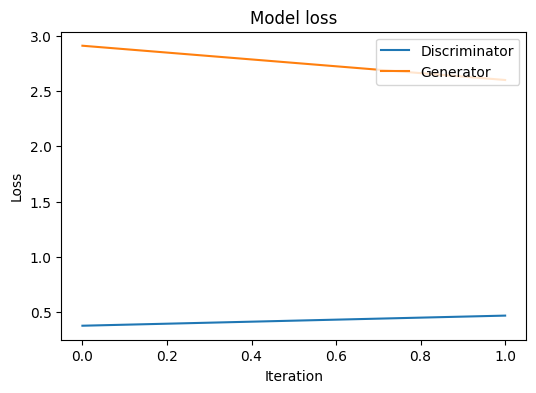

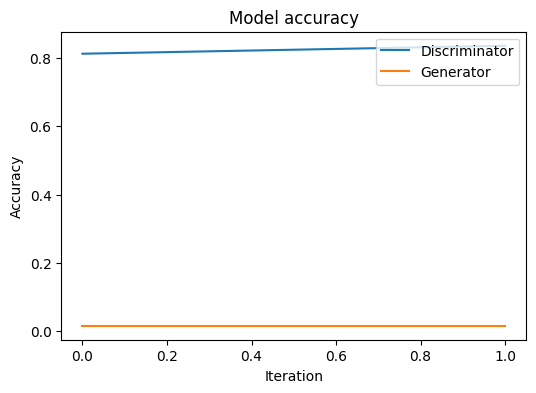

2/2 [==============================] - 0s 4ms/step
>1875, dr[0.767,0.625], df[0.507,0.844], g[1.975,0.047]
2/2 [==============================] - 0s 4ms/step
>1876, dr[0.350,0.797], df[0.388,0.922], g[2.047,0.062]
2/2 [==============================] - 0s 4ms/step
>1877, dr[0.601,0.688], df[0.445,0.797], g[2.286,0.000]
2/2 [==============================] - 0s 4ms/step
>1878, dr[0.403,0.766], df[0.275,0.953], g[1.891,0.047]
2/2 [==============================] - 0s 7ms/step
>1879, dr[0.518,0.703], df[0.424,0.812], g[2.074,0.047]
2/2 [==============================] - 0s 4ms/step
>1880, dr[0.425,0.781], df[0.334,0.922], g[1.860,0.078]
2/2 [==============================] - 0s 7ms/step
>1881, dr[0.629,0.672], df[0.409,0.891], g[1.972,0.047]
2/2 [==============================] - 0s 5ms/step
>1882, dr[0.394,0.797], df[0.542,0.781], g[2.630,0.016]
2/2 [==============================] - 0s 4ms/step
>1883, dr[0.438,0.781], df[0.223,0.953], g[2.438,0.031]
2/2 [==============================] 

>Saved: model_2811.h5


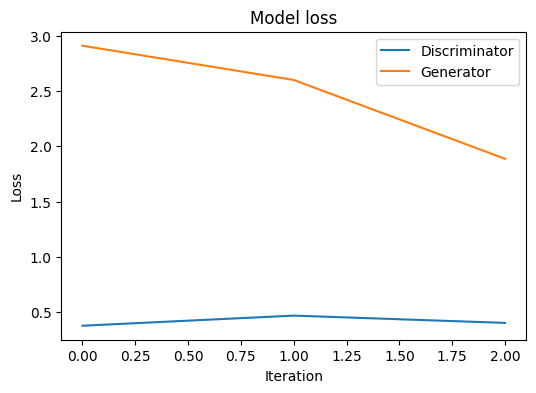

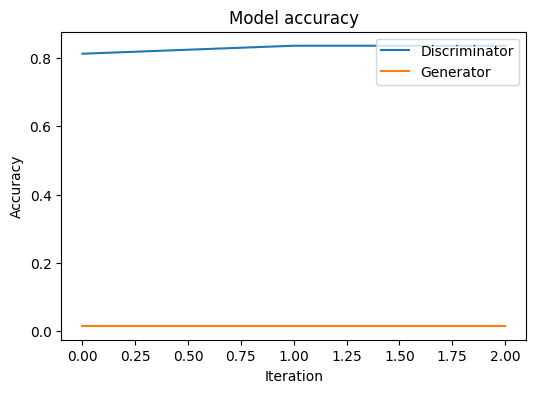

2/2 [==============================] - 0s 4ms/step
>2812, dr[0.655,0.578], df[0.576,0.766], g[1.768,0.016]
2/2 [==============================] - 0s 4ms/step
>2813, dr[0.366,0.750], df[0.296,0.938], g[1.872,0.047]
2/2 [==============================] - 0s 3ms/step
>2814, dr[0.528,0.688], df[0.333,0.922], g[1.760,0.016]
2/2 [==============================] - 0s 4ms/step
>2815, dr[0.467,0.734], df[0.367,0.875], g[1.672,0.016]
2/2 [==============================] - 0s 3ms/step
>2816, dr[0.449,0.688], df[0.420,0.906], g[1.579,0.031]
2/2 [==============================] - 0s 4ms/step
>2817, dr[0.466,0.734], df[0.411,0.906], g[1.633,0.094]
2/2 [==============================] - 0s 3ms/step
>2818, dr[0.608,0.609], df[0.519,0.750], g[1.697,0.047]
2/2 [==============================] - 0s 7ms/step
>2819, dr[0.397,0.750], df[0.365,0.859], g[1.599,0.062]
2/2 [==============================] - 0s 4ms/step
>2820, dr[0.446,0.766], df[0.437,0.828], g[1.894,0.047]
2/2 [==============================] 

>Saved: model_3748.h5


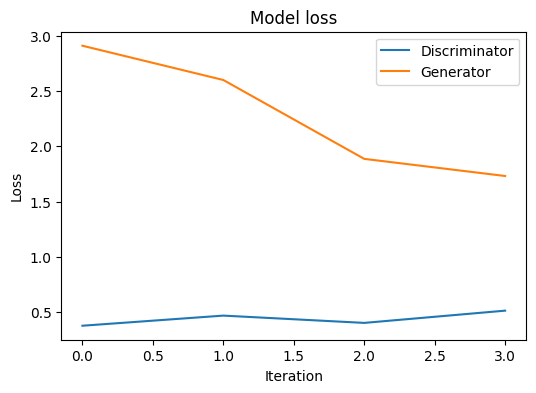

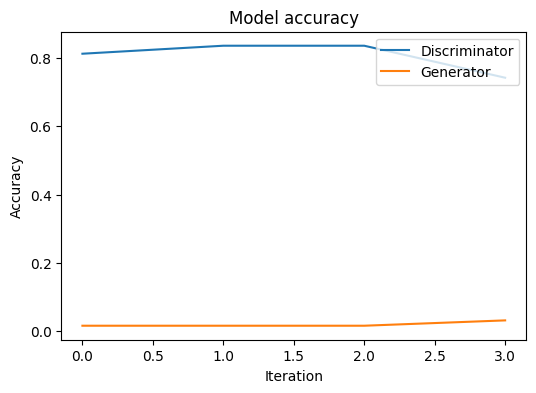

2/2 [==============================] - 0s 4ms/step
>3749, dr[0.573,0.656], df[0.406,0.875], g[1.805,0.031]
2/2 [==============================] - 0s 4ms/step
>3750, dr[0.514,0.719], df[0.417,0.875], g[1.536,0.109]
2/2 [==============================] - 0s 4ms/step
>3751, dr[0.607,0.562], df[0.726,0.641], g[1.441,0.141]
2/2 [==============================] - 0s 3ms/step
>3752, dr[0.406,0.734], df[0.455,0.859], g[1.495,0.047]
2/2 [==============================] - 0s 7ms/step
>3753, dr[0.555,0.609], df[0.412,0.859], g[1.632,0.062]
2/2 [==============================] - 0s 6ms/step
>3754, dr[0.464,0.719], df[0.435,0.875], g[1.744,0.062]
2/2 [==============================] - 0s 4ms/step
>3755, dr[0.494,0.672], df[0.427,0.828], g[1.652,0.016]
2/2 [==============================] - 0s 3ms/step
>3756, dr[0.604,0.562], df[0.469,0.844], g[1.444,0.078]
2/2 [==============================] - 0s 10ms/step
>3757, dr[0.391,0.781], df[0.465,0.844], g[1.459,0.062]
2/2 [==============================]

>Saved: model_4685.h5


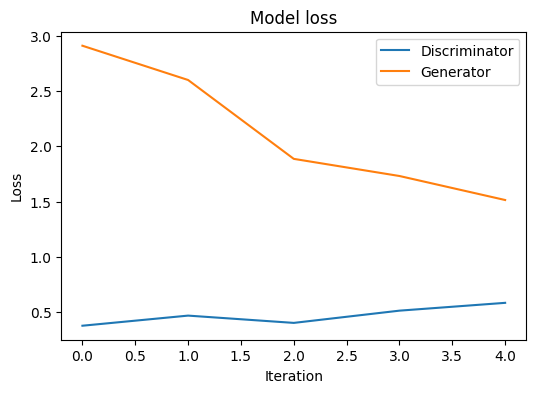

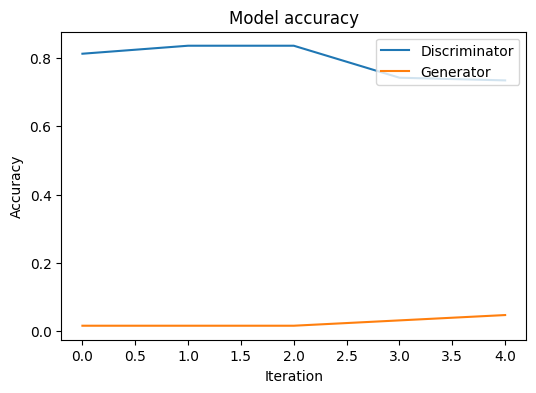

2/2 [==============================] - 0s 3ms/step
>4686, dr[0.385,0.750], df[0.409,0.875], g[1.573,0.047]
2/2 [==============================] - 0s 5ms/step
>4687, dr[0.478,0.641], df[0.440,0.891], g[1.463,0.062]
2/2 [==============================] - 0s 4ms/step
>4688, dr[0.428,0.734], df[0.356,0.906], g[1.603,0.062]
2/2 [==============================] - 0s 5ms/step
>4689, dr[0.422,0.766], df[0.525,0.812], g[1.679,0.047]
2/2 [==============================] - 0s 3ms/step
>4690, dr[0.563,0.656], df[0.436,0.859], g[1.621,0.016]
2/2 [==============================] - 0s 3ms/step
>4691, dr[0.472,0.703], df[0.431,0.844], g[1.618,0.047]
2/2 [==============================] - 0s 4ms/step
>4692, dr[0.596,0.609], df[0.474,0.797], g[1.387,0.156]
2/2 [==============================] - 0s 4ms/step
>4693, dr[0.432,0.734], df[0.453,0.797], g[1.516,0.047]
2/2 [==============================] - 0s 4ms/step
>4694, dr[0.530,0.672], df[0.419,0.828], g[1.516,0.062]
2/2 [==============================] 

>Saved: model_5622.h5


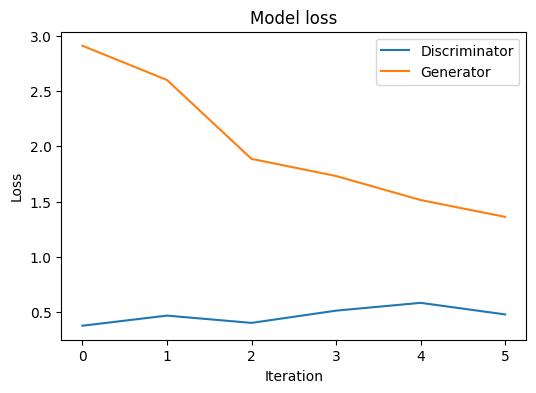

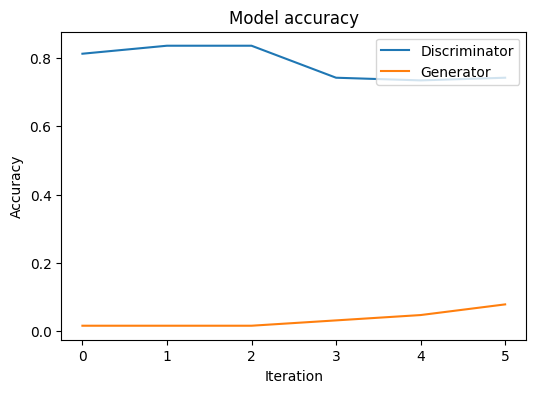

2/2 [==============================] - 0s 3ms/step
>5623, dr[0.484,0.703], df[0.470,0.859], g[1.337,0.094]
2/2 [==============================] - 0s 4ms/step
>5624, dr[0.538,0.641], df[0.544,0.844], g[1.466,0.031]
2/2 [==============================] - 0s 3ms/step
>5625, dr[0.582,0.609], df[0.529,0.859], g[1.534,0.047]
2/2 [==============================] - 0s 3ms/step
>5626, dr[0.591,0.656], df[0.371,0.922], g[1.432,0.031]
2/2 [==============================] - 0s 3ms/step
>5627, dr[0.643,0.609], df[0.513,0.828], g[1.192,0.125]
2/2 [==============================] - 0s 4ms/step
>5628, dr[0.542,0.641], df[0.433,0.922], g[1.188,0.156]
2/2 [==============================] - 0s 4ms/step
>5629, dr[0.482,0.672], df[0.610,0.734], g[1.203,0.109]
2/2 [==============================] - 0s 6ms/step
>5630, dr[0.527,0.703], df[0.465,0.750], g[1.375,0.109]
2/2 [==============================] - 0s 3ms/step
>5631, dr[0.412,0.750], df[0.452,0.859], g[1.274,0.188]
2/2 [==============================] 

>Saved: model_6559.h5


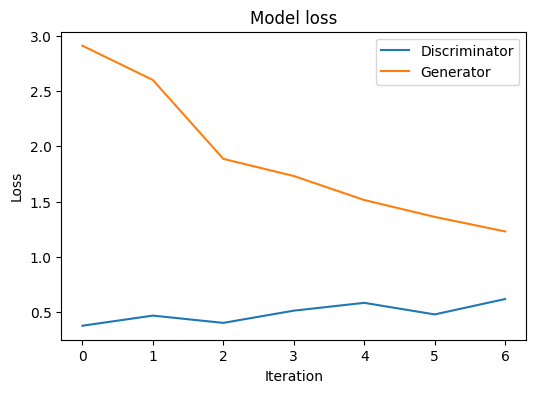

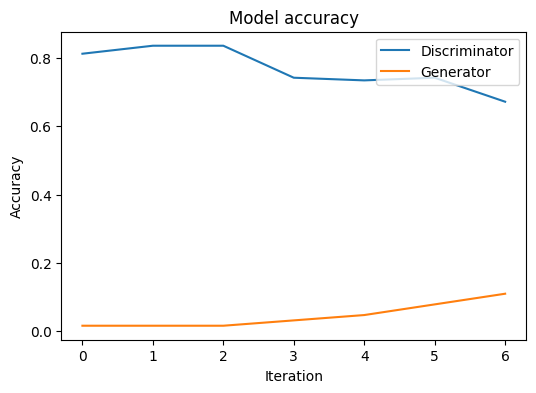

2/2 [==============================] - 0s 4ms/step
>6560, dr[0.587,0.609], df[0.538,0.750], g[1.293,0.094]
2/2 [==============================] - 0s 5ms/step
>6561, dr[0.702,0.562], df[0.549,0.812], g[1.255,0.047]
2/2 [==============================] - 0s 8ms/step
>6562, dr[0.672,0.547], df[0.523,0.828], g[1.190,0.125]
2/2 [==============================] - 0s 4ms/step
>6563, dr[0.558,0.656], df[0.565,0.781], g[1.242,0.094]
2/2 [==============================] - 0s 3ms/step
>6564, dr[0.515,0.656], df[0.527,0.797], g[1.225,0.078]
2/2 [==============================] - 0s 4ms/step
>6565, dr[0.809,0.422], df[0.559,0.781], g[1.200,0.203]
2/2 [==============================] - 0s 9ms/step
>6566, dr[0.635,0.547], df[0.598,0.781], g[1.259,0.109]
2/2 [==============================] - 0s 4ms/step
>6567, dr[0.642,0.578], df[0.562,0.812], g[1.197,0.047]
2/2 [==============================] - 0s 4ms/step
>6568, dr[0.655,0.516], df[0.500,0.828], g[1.198,0.062]
2/2 [==============================] 

>Saved: model_7496.h5


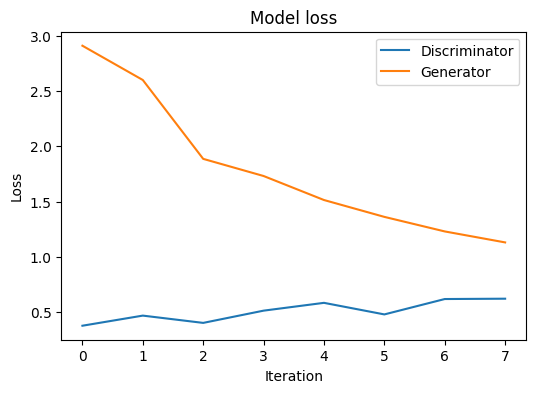

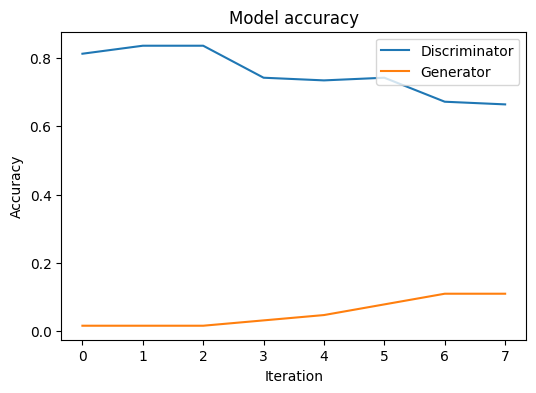

2/2 [==============================] - 0s 3ms/step
>7497, dr[0.630,0.609], df[0.691,0.688], g[1.102,0.094]
2/2 [==============================] - 0s 7ms/step
>7498, dr[0.595,0.625], df[0.588,0.766], g[1.179,0.109]
2/2 [==============================] - 0s 3ms/step
>7499, dr[0.715,0.484], df[0.512,0.859], g[1.137,0.125]
2/2 [==============================] - 0s 7ms/step
>7500, dr[0.638,0.562], df[0.604,0.703], g[1.071,0.125]
2/2 [==============================] - 0s 6ms/step
>7501, dr[0.477,0.656], df[0.515,0.812], g[1.151,0.141]
2/2 [==============================] - 0s 4ms/step
>7502, dr[0.519,0.688], df[0.561,0.766], g[1.143,0.188]
2/2 [==============================] - 0s 6ms/step
>7503, dr[0.622,0.562], df[0.414,0.953], g[1.089,0.172]
2/2 [==============================] - 0s 4ms/step
>7504, dr[0.635,0.562], df[0.570,0.781], g[1.122,0.141]
2/2 [==============================] - 0s 5ms/step
>7505, dr[0.516,0.688], df[0.626,0.766], g[1.060,0.203]
2/2 [==============================] 

>Saved: model_8433.h5


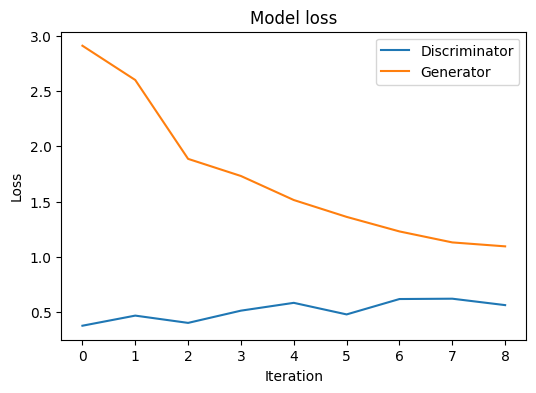

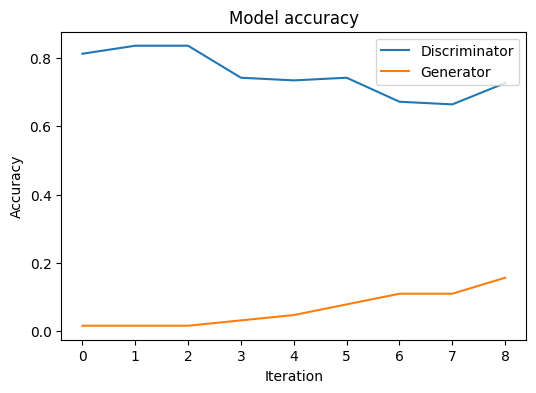

2/2 [==============================] - 0s 5ms/step
>8434, dr[0.676,0.516], df[0.677,0.641], g[1.108,0.141]
2/2 [==============================] - 0s 4ms/step
>8435, dr[0.582,0.656], df[0.559,0.797], g[1.054,0.141]
2/2 [==============================] - 0s 4ms/step
>8436, dr[0.585,0.562], df[0.487,0.781], g[1.183,0.125]
2/2 [==============================] - 0s 4ms/step
>8437, dr[0.563,0.641], df[0.608,0.688], g[1.246,0.125]
2/2 [==============================] - 0s 4ms/step
>8438, dr[0.627,0.531], df[0.552,0.797], g[1.144,0.156]
2/2 [==============================] - 0s 4ms/step
>8439, dr[0.543,0.672], df[0.577,0.766], g[1.138,0.141]
2/2 [==============================] - 0s 3ms/step
>8440, dr[0.568,0.594], df[0.602,0.719], g[1.138,0.109]
2/2 [==============================] - 0s 5ms/step
>8441, dr[0.716,0.469], df[0.560,0.844], g[1.236,0.078]
2/2 [==============================] - 0s 3ms/step
>8442, dr[0.562,0.688], df[0.607,0.781], g[1.182,0.125]
2/2 [==============================] 

>Saved: model_9370.h5


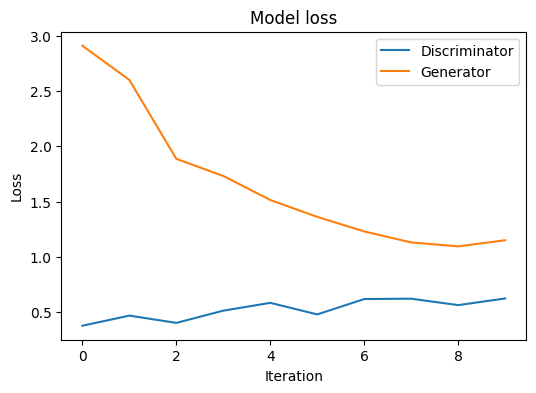

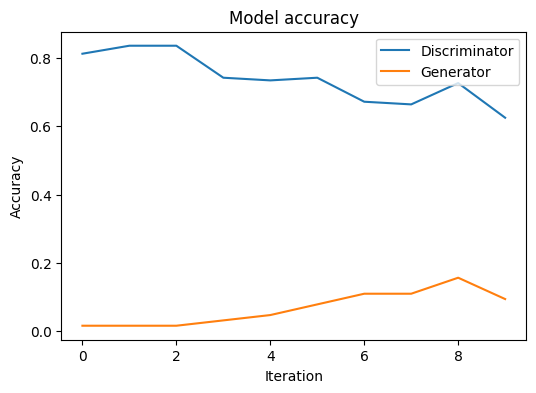

In [18]:
train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=10, n_batch=64)


4/4 [==============================] - 0s 2ms/step


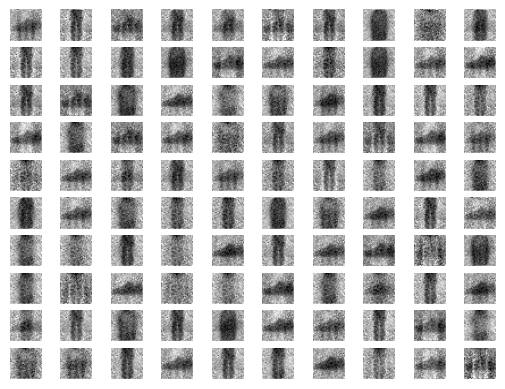

In [20]:
# load one of the saved models and try and generate fake samples
model = load_model('model_0937.h5')
latent_dim = 5
n_examples = 100
latent_points = generate_latent_points(latent_dim, n_examples)
X  = model.predict(latent_points)
X = (X + 1) / 2.0
save_plot(X, n_examples)